# Basic text classification

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multi-class classifier to predict the tag for a programming question on Stack Overflow.


In [1]:
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow.keras import layers

## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.


### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

#dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 7s 0us/step


### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

## remove the unsup directory from train

In [3]:
!rm -rf /content/aclImdb/train/unsup

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.
Then calling text_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of texts from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set).

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [4]:
batch_size = 32

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,  validation_split=0.2,
    subset='training', seed=42)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [5]:
for element in raw_train_ds.take(1):
  print(element)

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)',
       b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose persp

In [6]:
for element in raw_train_ds.take(1).as_numpy_iterator():
  print(element)

(array([b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up.",
       b'Caution: May contain spoilers...<br /><br />I\'ve seen this movie 3 times & I\'ve liked it every time. Upon seeing it again, I\'m always reminded of how good it is. An HBO TV movie- very well done like most of their movies are- this would\'ve gotten Oscars for it\'s performances had it been released for general distribution instead of made for TV.<br /><

As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [7]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />There\'s a 

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section.

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [8]:
raw_train_ds.class_names

['neg', 'pos']

In [9]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [10]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation', seed=42)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [11]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [12]:
import string
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                           '[%s]' % re.escape(string.punctuation), '')

Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [13]:
max_features = 10000
sequence_length = 250
# create the layer vectorize_layer
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

In [14]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [15]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [16]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Recipe for one of the worst movies of all time: a she-male villain who looks like it escaped from the WWF, has terrible aim with a gun that has inconsistent effects (the first guy she shoots catches on fire but when she shoots anyone else they just disappear) and takes time out to pet a deer. Then you got the unlikable characters, 30 year old college students, a lame attempt at a surprise ending and lots, lots more. Avoid at all costs.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[9257,   15,   28,    5,    2,  241,   91,    5,   30,   58,    4,
           1, 1011,   36,  262,   38,    9, 3891,   35,    2,    1,   43,
         382, 5223,   16,    4, 1113,   12,   43, 5739,  300,    2,   83,
         225,   55, 3209, 3898,   20,  973,   18,   51,   55, 3209,  250,
         320,   34,   40, 4386,    3,  294,   58,   44,    6, 2911,    4,
        6757,   92,   22,  184,    2, 4916,  100, 1221,  336,  161, 

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [17]:
vectorize_layer

In [18]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Create the model

It's time to create your neural network:

In [20]:
embedding_dim = 32

In [21]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1,activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320032    
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 320065 (1.22 MB)
Trainable params: 320065 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [22]:
from tensorflow.keras.models import Model
word_input=layers.Input(shape=(sequence_length,),dtype='float64')
x = layers.Embedding(max_features + 1, embedding_dim)(word_input)
x = layers.Dropout(0.2)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(1,activation='sigmoid')(x)
model = Model(word_input,out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 250, 32)           320032    
                                                                 
 dropout_2 (Dropout)         (None, 250, 32)           0         
                                                                 
 global_average_pooling1d_1  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                             

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, check out the [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings) tutorial.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [23]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) # tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [24]:
epochs = 10
history = model.fit(
    train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 9s 12ms/step - loss: 0.6468 - accuracy: 0.7058 - val_loss: 0.5724 - val_accuracy: 0.7884
Epoch 2/10
625/625 [==============================] - 9s 14ms/step - loss: 0.4896 - accuracy: 0.8242 - val_loss: 0.4350 - val_accuracy: 0.8408
Epoch 3/10
625/625 [==============================] - 9s 14ms/step - loss: 0.3812 - accuracy: 0.8643 - val_loss: 0.3672 - val_accuracy: 0.8604
Epoch 4/10
625/625 [==============================] - 7s 12ms/step - loss: 0.3228 - accuracy: 0.8827 - val_loss: 0.3329 - val_accuracy: 0.8696
Epoch 5/10
625/625 [==============================] - 9s 15ms/step - loss: 0.2867 - accuracy: 0.8943 - val_loss: 0.3135 - val_accuracy: 0.8732
Epoch 6/10
625/625 [==============================] - 8s 13ms/step - loss: 0.2594 - accuracy: 0.9046 - val_loss: 0.3012 - val_accuracy: 0.8756
Epoch 7/10
625/625 [==============================] - 10s 15ms/step - loss: 0.2383 - accuracy: 0.9128 - val_loss: 0.2935 - val_accuracy: 0.879

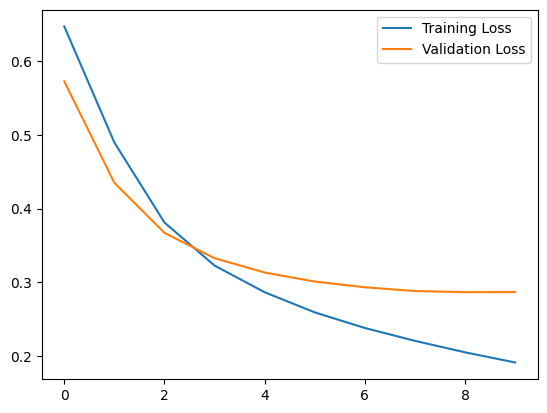

In [25]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()

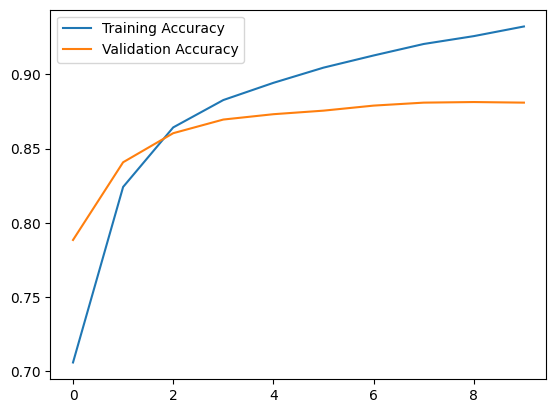

In [26]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [27]:
test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

782/782 [==============================] - 5s 6ms/step - loss: 0.3084 - accuracy: 0.8732
Test Loss: 0.30841925740242004
Test Accuracy: 0.873199999332428


# Model # 02

In [28]:
from tensorflow.keras.models import Model
word_input=layers.Input(shape=(sequence_length,),dtype='float64')
x = layers.Embedding(max_features + 1, embedding_dim)(word_input)
x = layers.Dropout(0.2)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(1,activation='sigmoid')(x)
model = Model(word_input,out)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 250, 32)           320032    
                                                                 
 dropout_4 (Dropout)         (None, 250, 32)           0         
                                                                 
 global_average_pooling1d_2  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                           

In [29]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) # tf.metrics.BinaryAccuracy(threshold=0.0))

In [30]:
# Train the model (example, assuming train_ds and val_ds are defined)
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 9s 12ms/step - loss: 0.4649 - accuracy: 0.7821 - val_loss: 0.3075 - val_accuracy: 0.8738
Epoch 2/10
625/625 [==============================] - 9s 15ms/step - loss: 0.2498 - accuracy: 0.9015 - val_loss: 0.3113 - val_accuracy: 0.8706
Epoch 3/10
625/625 [==============================] - 9s 14ms/step - loss: 0.1912 - accuracy: 0.9298 - val_loss: 0.3872 - val_accuracy: 0.8428
Epoch 4/10
625/625 [==============================] - 7s 12ms/step - loss: 0.1568 - accuracy: 0.9453 - val_loss: 0.3296 - val_accuracy: 0.8738
Epoch 5/10
625/625 [==============================] - 9s 15ms/step - loss: 0.1261 - accuracy: 0.9580 - val_loss: 0.3869 - val_accuracy: 0.8602
Epoch 6/10
625/625 [==============================] - 8s 13ms/step - loss: 0.1043 - accuracy: 0.9671 - val_loss: 0.4054 - val_accuracy: 0.8654
Epoch 7/10
625/625 [==============================] - 8s 13ms/step - loss: 0.0867 - accuracy: 0.9734 - val_loss: 0.4363 - val_accuracy: 0.8714

In [31]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


782/782 [==============================] - 3s 4ms/step - loss: 0.7260 - accuracy: 0.8342
Test Loss: 0.7259745597839355
Test Accuracy: 0.8342000246047974


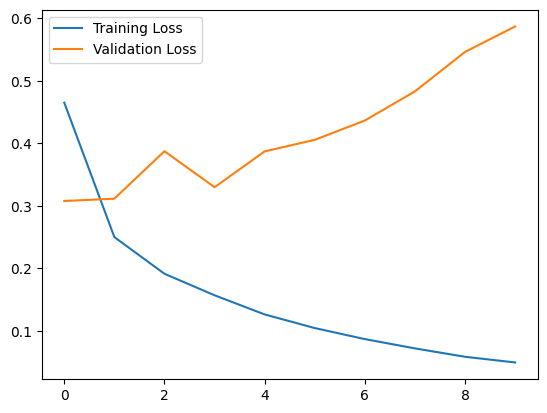

In [32]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()

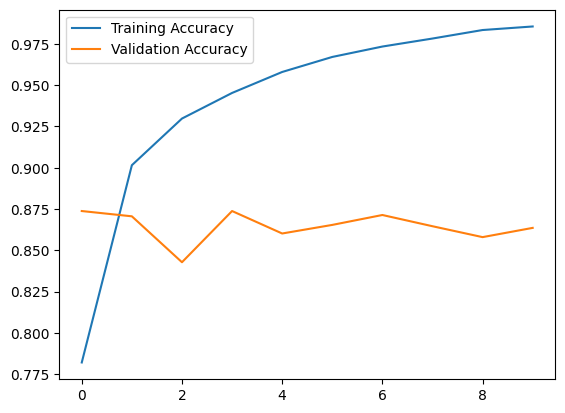

In [33]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()

# Model # 03

In [34]:
# Define your model
word_input = layers.Input(shape=(sequence_length,), dtype='float64')
x = layers.Embedding(max_features + 1, embedding_dim)(word_input)
x = layers.Dropout(0.5)(x)  # Increased dropout rate
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(256, activation='relu')(x)  # Increased number of units
x = layers.Dropout(0.5)(x)  # Increased dropout rate
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Increased dropout rate
out = layers.Dense(1, activation='sigmoid')(x)
model = Model(word_input,out)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 250, 32)           320032    
                                                                 
 dropout_6 (Dropout)         (None, 250, 32)           0         
                                                                 
 global_average_pooling1d_3  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               8448      
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                           

In [35]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) # tf.metrics.BinaryAccuracy(threshold=0.0))

In [36]:
# Train the model (example, assuming train_ds and val_ds are defined)
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 10s 14ms/step - loss: 0.4691 - accuracy: 0.7527 - val_loss: 0.3030 - val_accuracy: 0.8776
Epoch 2/10
625/625 [==============================] - 9s 15ms/step - loss: 0.2594 - accuracy: 0.8981 - val_loss: 0.2915 - val_accuracy: 0.8772
Epoch 3/10
625/625 [==============================] - 8s 13ms/step - loss: 0.2059 - accuracy: 0.9233 - val_loss: 0.3014 - val_accuracy: 0.8794
Epoch 4/10
625/625 [==============================] - 8s 12ms/step - loss: 0.1711 - accuracy: 0.9381 - val_loss: 0.3217 - val_accuracy: 0.8742
Epoch 5/10
625/625 [==============================] - 9s 14ms/step - loss: 0.1472 - accuracy: 0.9475 - val_loss: 0.3636 - val_accuracy: 0.8646
Epoch 6/10
625/625 [==============================] - 9s 15ms/step - loss: 0.1257 - accuracy: 0.9549 - val_loss: 0.3787 - val_accuracy: 0.8714
Epoch 7/10
625/625 [==============================] - 8s 13ms/step - loss: 0.1129 - accuracy: 0.9602 - val_loss: 0.4402 - val_accuracy: 0.869

In [37]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


782/782 [==============================] - 5s 6ms/step - loss: 0.6871 - accuracy: 0.8409
Test Loss: 0.6871097683906555
Test Accuracy: 0.8409199714660645


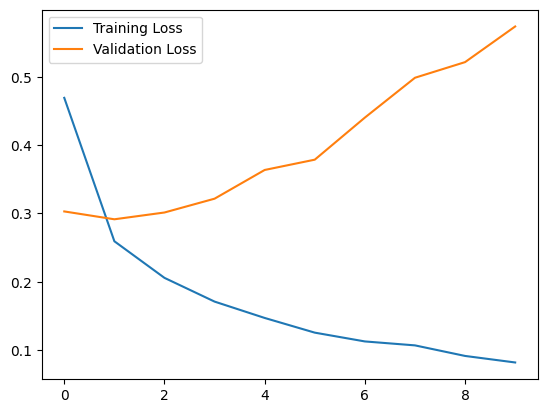

In [38]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()

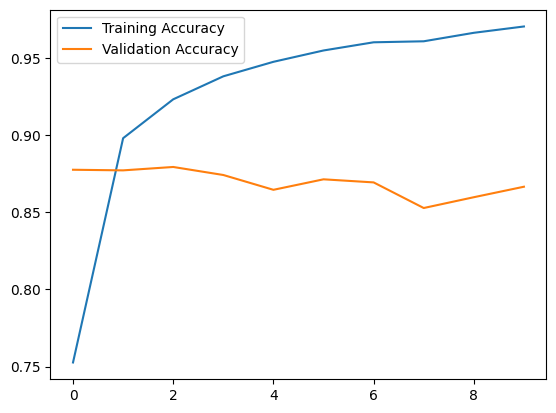

In [39]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()

# Model # 04

In [ ]:
# Define your model
word_input = layers.Input(shape=(sequence_length,), dtype='float64')
x = layers.Embedding(max_features + 1, embedding_dim)(word_input)
x = layers.SpatialDropout1D(0.5)(x)  # Spatial dropout
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)  # Bidirectional LSTM
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(1, activation='sigmoid')(x)
model = Model(word_input,out)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 250, 32)           320032    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 250, 32)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_1 (Bidirecti  (None, 250, 256)          164864    
 onal)                                                           
                                                                 
 global_max_pooling1d_1 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                           

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) # tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
# Train the model (example, assuming train_ds and val_ds are defined)
epochs = 3
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/3
625/625 [==============================] - 376s 592ms/step - loss: 0.4807 - accuracy: 0.7478 - val_loss: 0.3358 - val_accuracy: 0.8542
Epoch 2/3
625/625 [==============================] - 372s 596ms/step - loss: 0.2741 - accuracy: 0.8892 - val_loss: 0.2936 - val_accuracy: 0.8734
Epoch 3/3
625/625 [==============================] - 367s 587ms/step - loss: 0.2086 - accuracy: 0.9191 - val_loss: 0.2994 - val_accuracy: 0.8714


In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


782/782 [==============================] - 138s 176ms/step - loss: 0.3328 - accuracy: 0.8616
Test Loss: 0.33277463912963867
Test Accuracy: 0.8616399765014648


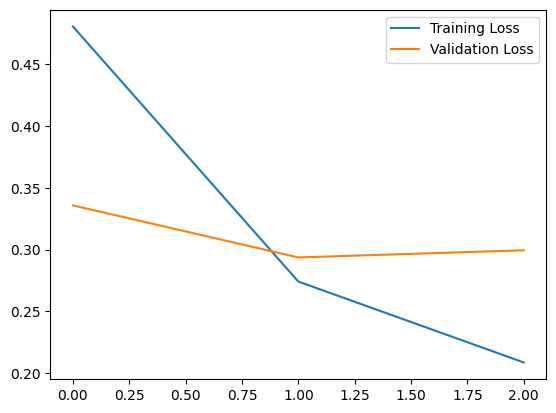

In [ ]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()

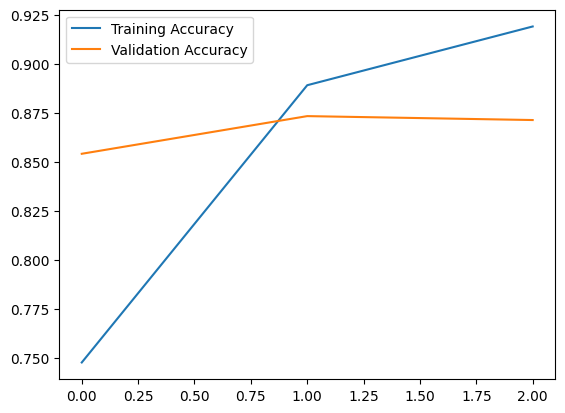

In [ ]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()

# Conclusion:
Compare to other models, The baseline model (Model 1) is overall good, It gives more accuracy compare to other results.